In [1]:
import datetime
import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import pyxirr
import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')
plt.style.use('seaborn-whitegrid')

class pct(float):
    def __str__(self):
        return '{:.4%}'.format(self)

In [2]:
# import formatted list of transaction
input_data = pd.read_csv('./test-portfolio.csv', sep=',', index_col='Date', parse_dates=True, ).sort_index()

In [3]:
# utilities
tickers = input_data.Ticker.unique()
tickers.sort()
start_date = input_data.index[0].date()
end_date = datetime.date(2020,1,29) # (2021,7,16)
timeline = pd.date_range(start=start_date, end=end_date)
years = timeline.shape[0]/365
day = datetime.timedelta(days=1)

In [4]:
transactions = pd.DataFrame(0, columns=tickers, index = timeline)
splits = pd.DataFrame(1, columns=tickers, index = timeline)
dividends = pd.DataFrame(0, columns=tickers, index = timeline)
prices = pd.DataFrame(0, columns=tickers, index = timeline)
fees = pd.DataFrame(0, columns=tickers, index = timeline)
portfolio = pd.DataFrame(0, columns=['Invested Capital'], index = timeline)

In [5]:
market_values = yf.download(list(tickers), start=start_date + day, end=end_date + day)['Adj Close']
market_values.loc[:,'LIQUIDITY']=1
market_values = market_values.asfreq(freq='1D', method='ffill')

[*********************100%***********************]  4 of 4 completed

1 Failed download:
- LIQUIDITY: No data found, symbol may be delisted


In [6]:
# record transactions per ticker
for date, transaction in input_data.iterrows():
    if transaction.Order == 'purchase' or transaction.Order == 'deposit':
        sign = 1
    else:
        sign = -1
    transactions.loc[date, transaction.Ticker] = sign * transaction.Quantity
    prices.loc[date, transaction.Ticker] = transaction.Price
    fees.loc[date, transaction.Ticker] = transaction.Fee

In [7]:
# keep track of invested capital
portfolio['Invested Capital'] = transactions.loc[:,'LIQUIDITY'].copy()
account = transactions.loc[:,'LIQUIDITY'].copy()

In [8]:
# insert cash movements
transactions.loc[:,'LIQUIDITY'] = transactions.loc[:,'LIQUIDITY'].values - np.sum((transactions.loc[:, transactions.columns != 'LIQUIDITY'].values*prices.loc[:, prices.columns != 'LIQUIDITY'].values),axis=1)  - np.sum(fees.values,axis=1)

In [9]:
for ticker in tickers:
    try:
        divs = yf.Ticker(ticker).dividends.loc[start_date + day : end_date + day]
        for date, div in divs.iteritems():
            dividends.loc[date, ticker] = div
        spls = yf.Ticker(ticker).splits.loc[start_date + day : end_date + day]
        for date, split in spls.iteritems():
            splits.loc[date, ticker] = split
    except:
        pass

for date in splits.index[::-1]:
    try:
        tomorrow = date + day
        splits.loc[date] = splits.loc[tomorrow] * splits.loc[date]
    except:
        pass

- LIQUIDITY: No data found, symbol may be delisted


In [10]:
holdings = transactions.copy()

# generate holdings from transactions
for date in holdings.index:
    try:
        yesterday = date - day
        holdings.loc[date] = transactions.loc[date] * splits.loc[date] + holdings.loc[yesterday]
        portfolio.loc[date, 'Invested Capital'] = portfolio.loc[date, 'Invested Capital'] + portfolio.loc[yesterday, 'Invested Capital']
    except:
        pass

In [11]:
holdings_values = pd.DataFrame((holdings.values * market_values.values), columns=tickers, index = timeline)

In [12]:
portfolio['Value'] = holdings_values.sum(axis=1)
portfolio['P/L'] = portfolio['Value']-portfolio['Invested Capital']
portfolio['%P/L'] = portfolio['P/L']/portfolio['Invested Capital']
portfolio['%day'] = portfolio['Value'].pct_change()
portfolio['Log Ret'] = np.log(portfolio['Value']/portfolio['Value'].shift(1))

In [13]:
cash_flows = -account + np.sum(dividends.values,axis=1) - np.sum(fees.values,axis=1)
cash_flows.iloc[-1] = portfolio['Value'].iloc[-1]

In [14]:
asset_allocation = holdings_values.copy()
asset_allocation = asset_allocation.divide(portfolio['Value'], axis=0)

XIRR: 25.0201% 
Annualised XIRR 96.1292%


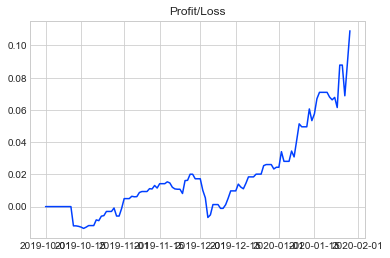

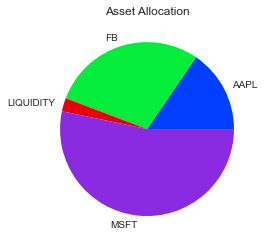

In [16]:
xirr = pyxirr.xirr(cash_flows.index, cash_flows.values)
ann_xirr = (1+xirr)**(365/portfolio.shape[0])-1
print('XIRR:', pct(xirr), '\nAnnualised XIRR', pct(ann_xirr))

plt.title('Profit/Loss')
plt.plot(portfolio['%P/L'])
plt.show()
plt.title('Asset Allocation')
plt.pie(asset_allocation.iloc[-1], labels=asset_allocation.columns)
plt.show()